# Capstone Project: Recipe Analysis and Classification for Meal Kit Services

# Part 3: Exploratory Data Analysis: Clustering

Clustering can be using to detect patterns within datasets. In this section, I will use dimensionality reduction techniques to cluster recipes based on their ingredients and visualize the results. This can help visualize the similarities and differences between cuisines. 

### Contents:
1. [Principal Component Analysis](#1.-PCA:-Principal-Component-Analysis)
2. [t-Distributed Stochastic Neighbor Embedding](#2.-t-SNE:-t-distributed-Stochastic-Neighbor-Embedding)
3. [K-Means Clustering](#3.-K-Means-Clustering)

In [25]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ast
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from pylab import *
from scipy import *
from sklearn.cluster import KMeans

import pickle


import warnings
warnings.filterwarnings('ignore')

In [2]:
# import dataset
data = pd.read_csv('../data/processed/cleaned_data.csv', sep=',', 
                   converters={'ingredients':ast.literal_eval,
                               'ingredientLines': ast.literal_eval})

In [3]:
cuisine_list = list(set(data.cuisine))

In [4]:
def convert_to_dict(arr):
    ''' Helper function to convect an array of ingredients to a dictionary '''
    d={}
    for a in arr:
        d[a]=1
    return d

# bag of words per recipe
data['bow'] = data.ingredients.apply(convert_to_dict)

## 1. PCA: Principal Component Analysis

* PCA maps data to a lower-dimensional space while maximizing the variance of the data in the lower-dimensional representation.
* I will represent each recipe as a one hot encoded vector of its ingredients using DictVectorizer
* Then, I will project the high dimensional one hot encoded vector to a 2 dimensional space using PCA using the cosine kernel as a distance metric to look for similarity between two vectors

In [12]:
def generate_pca(data, cuisines, n, random_state = 23):
    ''' Helper function to visualize pca plot '''
    data_filtered = data[data.cuisine.isin(cuisines)]
    data_filtered = data_filtered.sample(n, random_state = random_state)
    
    # One hot encoding of the ingredients
    vectorizer = DictVectorizer(sparse=False)
    X = vectorizer.fit_transform(data_filtered.bow.tolist())
    y = data_filtered.cuisine.astype('category').cat.codes
    cuisine_list = data_filtered.cuisine.astype('category').cat.categories
    
    X_pca = KernelPCA(n_components=2, kernel='cosine', n_jobs=2).fit_transform(X)
    
    plotting_df = pd.DataFrame(data=X_pca[:,:2], columns=['x','y'])
    plotting_df['cuisine']= cuisine_list[y].tolist()
    
    
    fig = sns.lmplot("x", "y", data=plotting_df, palette='hls', hue='cuisine', fit_reg=False, size = 10);
    plt.title('PCA: Visualization of Ingredients By Cuisine', fontsize=16)
    return fig

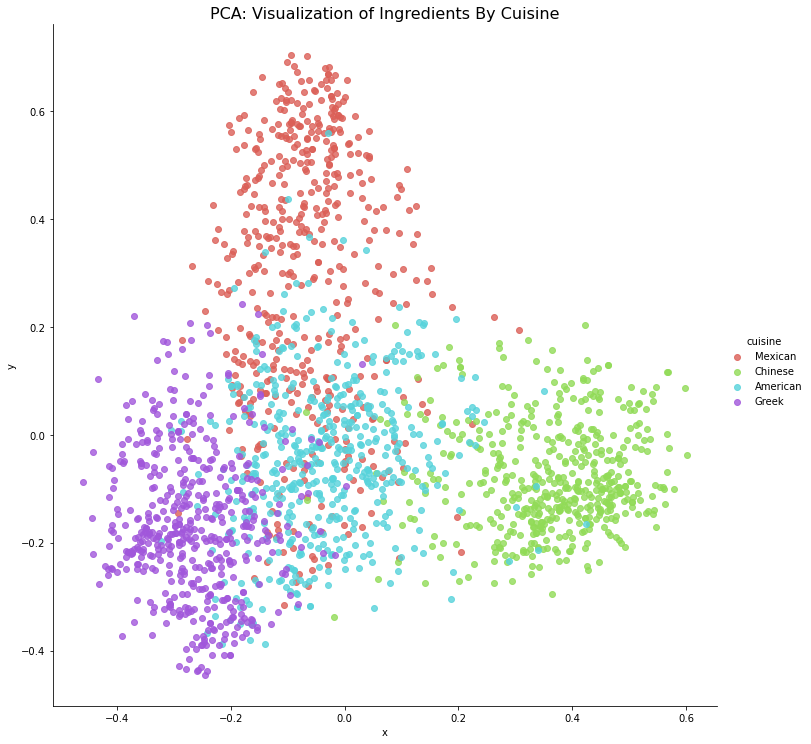

In [13]:
pca_sample = generate_pca(data, ['Chinese','Mexican', 'American', 'Greek'], 2000)
with open('../models/clustering/pca_sample.pkl', 'wb') as file:   
    pickle.dump(pca_sample, file)

- With 4 cuisines from different regions, we can see Chinese and Greek recipes have the least overlap in terms of ingredients, while American recipes seem to overlap the most with all 3 other cuisines.

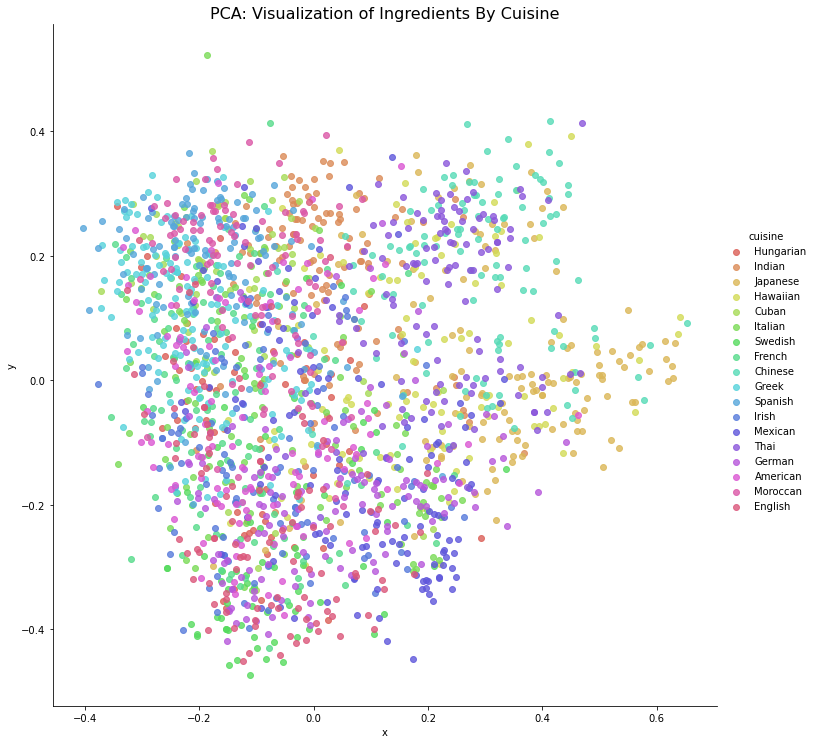

In [14]:
pca_all = generate_pca(data, cuisine_list, 2000)
with open('../models/clustering/pca_all.pkl', 'wb') as file:   
    pickle.dump(pca_all, file)

- Plotting all cuisines, it is harder to see clear differences between cuisines -> let's see if using t-SNE provides clearer distinctions

## 2. t-SNE: t-distributed Stochastic Neighbor Embedding

- While PCA is a linear dimension reduction technique that seeks to maximize variance, it can lead to poor visualization when dealing with non-linear data
- t-distributed stochastic neighbor embedding is another technique for dimensionality reduction which is based on probability distributions - unlike PCA, it can find non-linear relationships between datapoints


In [19]:
def generate_tsne(data, cuisines, n, random_state = 23):
    ''' Helper function to visualize tsne plot '''
    data_filtered = data[data.cuisine.isin(cuisines)]
    data_filtered = data_filtered.sample(n, random_state = random_state)

    # One hot encoding of the ingredients
    vectorizer = DictVectorizer(sparse=False)
    X = vectorizer.fit_transform(data_filtered.bow.tolist())
    y = data_filtered.cuisine.astype('category').cat.codes
    cuisine_list = data_filtered.cuisine.astype('category').cat.categories
    
    
    X_to_reduce = squareform(pdist(X, metric='cosine'))
    X_tsne = TSNE(metric='precomputed').fit_transform(X_to_reduce)
    
    plotting_df = pd.DataFrame(data=X_tsne[:,:2], columns=['x','y'])
    plotting_df['cuisine']= cuisine_list[y].tolist()
    
    
    fig = sns.lmplot("x", "y", data=plotting_df, palette='hls', hue='cuisine', fit_reg=False, size = 10);
    return fig

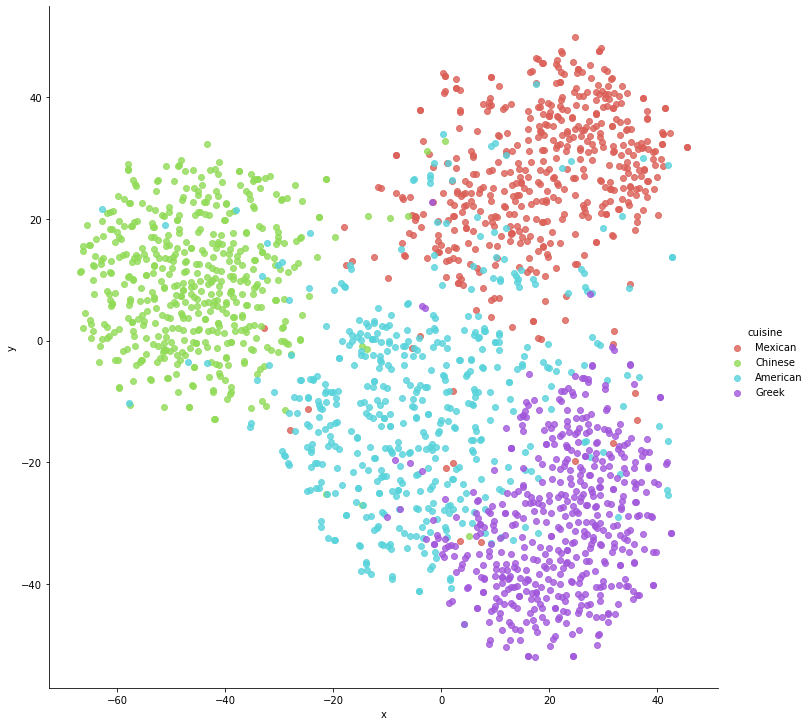

In [20]:
tsne_sample = generate_tsne(data, ['Chinese','Mexican', 'American', 'Greek'], 2000)
with open('../models/clustering/tsne_sample.pkl', 'wb') as file:   
    pickle.dump(tsne_sample, file)

* t-SNE is able to visualize the differences between cuisines based on ingredients a lot clearer than PCA
* It is easy to see that Chinese, Mexican, and Greek recipes do not have much overlap, while American recipes tend to overlap more with Greek and Mexican recipes

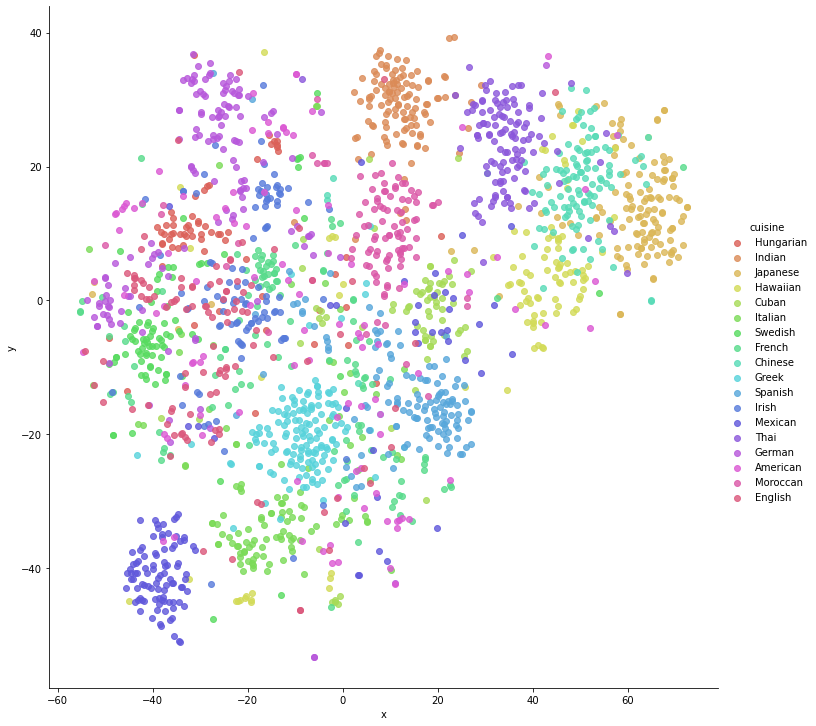

In [109]:
tsne_all = generate_tsne(data, cuisine_list, 2000)
with open('../models/clustering/tsne_all.pkl', 'wb') as file:   
    pickle.dump(tsne_all, file)

* Using all cuisines, t-SNE presents a much clearer view of how distinguishable different cuisines are based on their ingredients
* It is evident some cuisines are more easy to distinguish - for example, Mexican, Indian, and Thai recipes do not overlap that much with other cuisines
* There is an interesting overlap between Chinese, Haiwaiian and Japanese cuisines
* English and American are very dispersed and overlap with several other cuisines

## 3. K-Means Clustering

- Another method for visualizing recipes based on their ingredients is k-means clustering
- K-Means clustering is an unsupervised machine learning algorithm that will assignn every data point to one of k clusters by reducing the in-cluster sum of squares
- Instead of taking a small sample of my dataset, for K-means clustering, I will aggregate my data set by cuisine and represent each cuisine as a one hot encoded vector of the unique ingredients from all recipes in that cuisine
- I will then use PCA to reduce the vector to 2 components, followed by using k-means algorithm with k = 5 to cluster cuisines based on ingredients

In [33]:
# Group by cuisine and aggregate the data
data_agg = data[['cuisine','ingredients','id']]
data_agg = data_agg.groupby('cuisine').apply(lambda x: x.sum())
data_agg = data_agg.drop(columns=['cuisine','id'])
data_agg = data_agg.reset_index()


## Get all of the unique ingredients as features
features_all_list = []
 
for i in data.ingredients:
    features_all_list += i
    features = list(set(features_all_list))
    len(features)
    onehot_ingredients = np.zeros((data_agg.shape[0], len(features)))
    feature_lookup = sorted(features)

In [35]:
data_agg.head()

,cuisine,ingredients
0,American,"[black pepper, dried plum, allpurpose flour, g..."
1,Chinese,"[hoisin sauce, water, spice, star anise, garli..."
2,Cuban,"[black pepper, lime, zest, garlic, bell pepper..."
3,English,"[worcestershire sauce, sweet potato, garlic, c..."
4,French,"[black pepper, olive oil, pepper, shallot, che..."


In [60]:
# bag of words per cuisine
data_agg['bow'] = data_agg.ingredients.apply(convert_to_dict)

# one hot encode ingredients per cuisine
vectorizer = DictVectorizer(sparse=False)
X = vectorizer.fit_transform(data_agg.bow.tolist())
y = data_agg.cuisine.astype('category').cat.codes
cuisine_list = data_agg.cuisine.astype('category').cat.categories

# use PCA for dimensionality reduction
X_reduced = KernelPCA(n_components=2, kernel='cosine', n_jobs=2).fit_transform(X)   


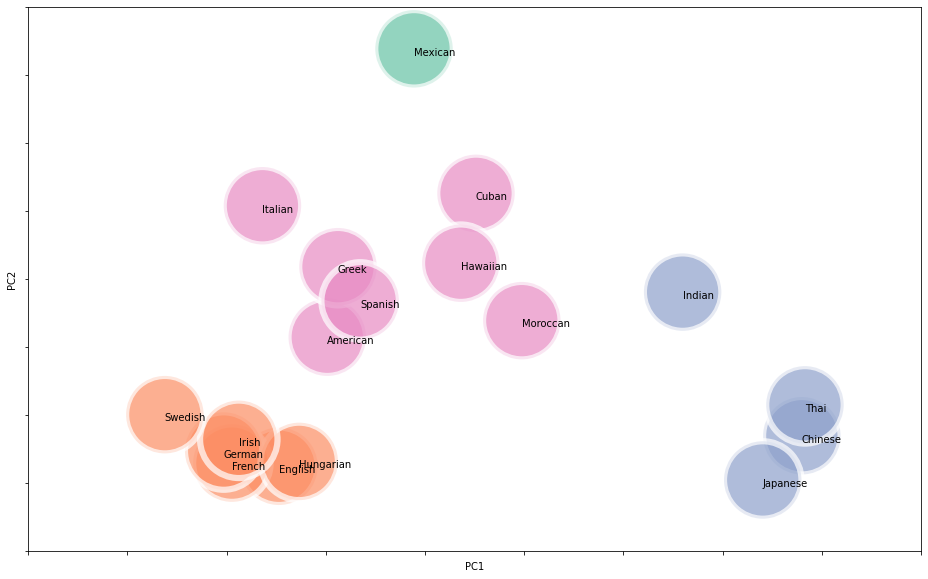

In [117]:
# 4 clusters

numOfClusters = 4

#instantiate kmeans
kmeans = KMeans(init='k-means++', n_clusters=numOfClusters, n_init=10)

# fit on reduced data
kmeans.fit(X_reduced)

# predict for reduced data
kmeans_pred = kmeans.predict(X_reduced)

kmeans_df = pd.DataFrame(X_reduced, index = data_agg.cuisine, columns = ['PC1', 'PC2'])
kmeans_df['kmeans'] = kmeans_pred
kmeans_df = kmeans_df.reset_index()


plt.figure(figsize = (16,10))
g = sns.scatterplot(data=kmeans_df, x="PC1", y="PC2", hue = "kmeans", 
                s=6000, alpha = 0.7, palette = 'Set2', legend = False)

for line in range(0,data_agg.shape[0]):
     plt.text(kmeans_df.PC1[line], kmeans_df.PC2[line]-.01, kmeans_df.cuisine[line], horizontalalignment='left', size='medium', color='black')
        
g.set(ylim=(-0.3, .5), xlim=(-.4, .5), xticklabels = [], yticklabels = []);

- The 4 clusters roughly match up to different regions - blue is Asian, orange is European, green is Latin American, while pink is a mixture of southern european/mediterranean and miscellaneous cuisines => maybe 5 clusters will help seperate these cuisines more accurately
- Interestingly, Cuban cuisine is more similar to Hawaiian than to Mexican

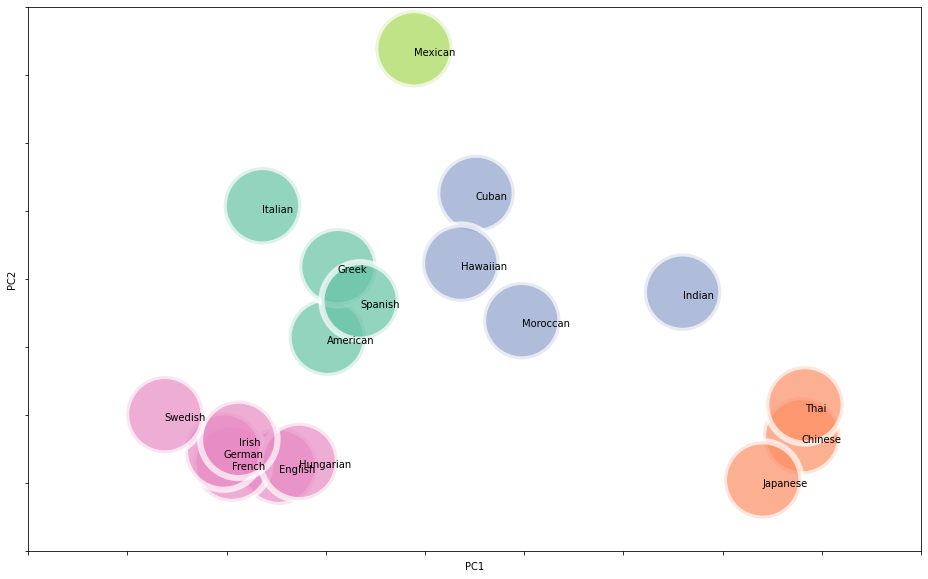

In [118]:
# 5 clusters

numOfClusters = 5

#instantiate kmeans
kmeans = KMeans(init='k-means++', n_clusters=numOfClusters, n_init=10)

# fit on reduced data
kmeans.fit(X_reduced)

# predict for reduced data
kmeans_pred = kmeans.predict(X_reduced)

kmeans_df = pd.DataFrame(X_reduced, index = data_agg.cuisine, columns = ['PC1', 'PC2'])
kmeans_df['kmeans'] = kmeans_pred
kmeans_df = kmeans_df.reset_index()


plt.figure(figsize = (16,10))
g = sns.scatterplot(data=kmeans_df, x="PC1", y="PC2", hue = "kmeans", 
                s=6000, alpha = 0.7, palette = 'Set2', legend = False)

for line in range(0,data_agg.shape[0]):
     plt.text(kmeans_df.PC1[line], kmeans_df.PC2[line]-.01, kmeans_df.cuisine[line], horizontalalignment='left', size='medium', color='black')
        
g.set(ylim=(-0.3, .5), xlim=(-.4, .5), xticklabels = [], yticklabels = []);

- With 5 clusters, there is a cluster of East Asian cuisines, Mexican cuisine, European cuisines, and Mediterranean/Southern European cuisines. 
- Interestingly, there is a cluster for Hawaiian, Moroccan, Indian, and Cuban cuisines which are all from different continents